# Capstone Webscrapping using BeautifulSoup


## Background

This project is to scrape data of Ethereum and in the end plot the data to see the volume movements of Ethereum. We will use the daily volume of Ethereum from CoinGecko website. CoinGecko is a Singapore based company that provides a data platform, digital currency prices, and fundamental analysis of the cryptocurrency market.

We are goint to scrape the transaction volume data from this site. Volume in cryptocurrency is the sum total of actual trades taking place. Usually, the higher the volume of cryptocurrency transactions, the more liquid the crypto market will be.

In this project we will focus on scraping the Ethereum volume data.

## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [160]:
import requests

url_get = requests.get('https://www.coingecko.com/en/coins/ethereum/historical_data/usd?start_date=2020-01-01&end_date=2021-06-30#panel')

To visualize what exactly you get from the `request.get`, we can use .content so ee what we exactly get, in here i slice it so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [161]:
url_get.content[1:500]

b'!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<link rel="shortcut icon" href="/favicon.ico">\n<link type="application/opensearchdescription+xml" rel="search" href="/OpensearchDescription.xml" />\n<title>Ethereum USD Historical Data | CoinGecko</title>\n<meta name="description" content="Get Ethereum (ETH) USD historical prices." />\n\n<link rel="preload" href="h'

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on your web browser. But we as human still confused what and where we can use that piece of code, so here where we use the beautifulsoup. Beautiful soup class will result a beautifulsoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects. 

Let's make Beautiful soup object and feel free to explore the object here.

In [162]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content,"html.parser")
print(type(soup))

<class 'bs4.BeautifulSoup'>


## Finding the right key to scrap the data & Extracting the right information

In this step we have inspected the website page of coingecko's Ethereum and to only get the table containing the Date and Volume data, we will need to get the table by selecting the `<tbody>` tag (first key).
    
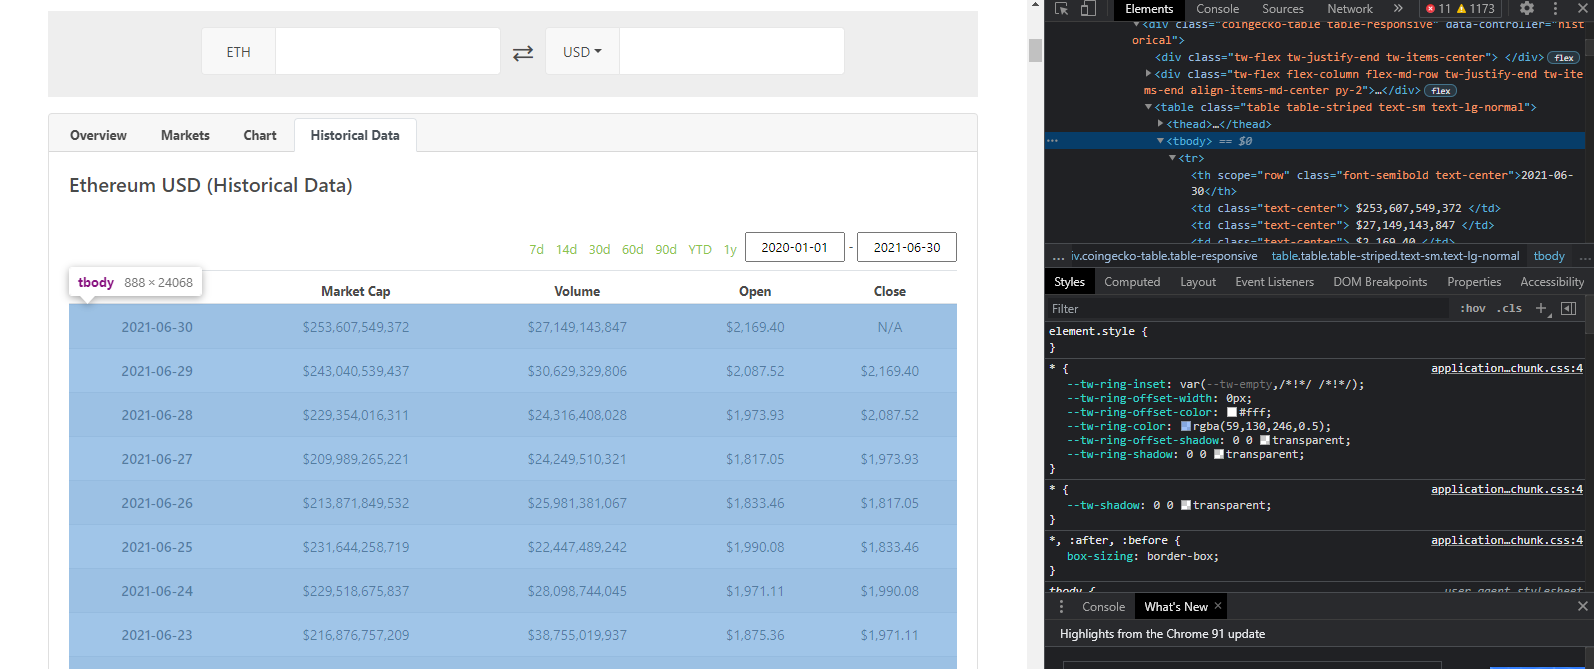

We will also be using beautifulsoup's method of preetify to make the data in the object easier to read (more preety).
We can read the data, limited to see the first 500 character. 

In [163]:
table = soup.find('tbody', attrs={'class':''})
print(table.prettify()[1:500])

tbody>
 <tr>
  <th class="font-semibold text-center" scope="row">
   2021-06-30
  </th>
  <td class="text-center">
   $253,607,549,372
  </td>
  <td class="text-center">
   $27,149,143,847
  </td>
  <td class="text-center">
   $2,169.40
  </td>
  <td class="text-center">
   N/A
  </td>
 </tr>
 <tr>
  <th class="font-semibold text-center" scope="row">
   2021-06-29
  </th>
  <td class="text-center">
   $243,040,539,437
  </td>
  <td class="text-center">
   $30,629,329,806
  </td>
  <td class="te


From the extracted data, we see from the data that we have 2 levels of data. 1 level is wrapped in the `<tr>` tag (with no class information) and inside it we see the repetition of:
- 1 `<th>` tag with class `font-semibold text-center` that contains the date. 
- 4 `<td>` tags with same class `text-center` that contains data of:
    - Market Cap
    - Volume
    - Open
    - Close
 

We will use the `find_all` function to get the tag that we want.
From the analysis above, we can see that in order to get the daily volume from the table, we will need two parts from each section of the row, which are:
1. the `<th>` tag for the date
2. the `<td>` with the volume data

In [164]:
table.find_all('th', attrs={'class':'font-semibold text-center'})[:5]

[<th class="font-semibold text-center" scope="row">2021-06-30</th>,
 <th class="font-semibold text-center" scope="row">2021-06-29</th>,
 <th class="font-semibold text-center" scope="row">2021-06-28</th>,
 <th class="font-semibold text-center" scope="row">2021-06-27</th>,
 <th class="font-semibold text-center" scope="row">2021-06-26</th>]

The `find_all` for the date `<th>` section looks good and can get the list of the dates that we want.

In [165]:
table.find_all('td', attrs={'text-center'})[:5]

[<td class="text-center">
 $253,607,549,372
 </td>,
 <td class="text-center">
 $27,149,143,847
 </td>,
 <td class="text-center">
 $2,169.40
 </td>,
 <td class="text-center">
 N/A
 </td>,
 <td class="text-center">
 $243,040,539,437
 </td>]

We see here that by using `find_all` on the `<td>` returns multiple data from the columns.
By analysing the data, we can see that the data that we want is the from the 2nd `<td>` tag, which in python that starts the index at 0, means second data is index 1.

Below we check the data.

In [166]:
table.find_all('td', attrs={'text-center'})[1]

<td class="text-center">
$27,149,143,847
</td>

Finding row length.

Now that we have the logic we need to get the specific data, to scrape all the data, we will need to know how many rows of data that we have for the scrapping process loop.

We can use the `len` function on the `<tr>` data (in this case we use `<tr>` because it represent the number of rows of data that we will need to loop) 

In [167]:
datarow = table.find_all('tr', attrs={'class':''})
row_length = len(datarow)
row_length

547

To actually scrape the data from the table, we will do a loop function using the for statement.

The details of the loop are as follows:
1. Create a placeholder for the data, we will use `temp`
2. We use the for statement, starting from 0 until the end of the list using the `len` on the datarow table.
3. On the scrapping process we have 3 steps:
    
    a. get the row: we loop the `<tr>` to get each row
    
    b. get the date text in the row: during each row loop, we get the `<th>` that contains the date
    
    c. get the volume text in the row: during each row loop, we get the 2nd (index [1]) `<td>` that contains the volume

4. append on the `temp` tuple

In [168]:
temp = [] #initiating a tuple

for i in range(0, len(datarow)):

    #scrapping process
    #get the row
    row = table.find_all('tr', attrs={'class':''})[i]
    #get the Date in the row
    dateVal = row.find_all('th', attrs={'class':'font-semibold text-center'})[0].text
    
    #get the Volume in the row
    volumeVal = row.find_all('td', attrs={'class':'text-center'})[1].text
    volumeVal = volumeVal.strip() #to remove excess white space

    temp.append((dateVal, volumeVal)) 
    
temp 

[('2021-06-30', '$27,149,143,847'),
 ('2021-06-29', '$30,629,329,806'),
 ('2021-06-28', '$24,316,408,028'),
 ('2021-06-27', '$24,249,510,321'),
 ('2021-06-26', '$25,981,381,067'),
 ('2021-06-25', '$22,447,489,242'),
 ('2021-06-24', '$28,098,744,045'),
 ('2021-06-23', '$38,755,019,937'),
 ('2021-06-22', '$39,499,960,408'),
 ('2021-06-21', '$26,235,850,447'),
 ('2021-06-20', '$20,456,963,375'),
 ('2021-06-19', '$26,204,484,921'),
 ('2021-06-18', '$25,708,624,827'),
 ('2021-06-17', '$26,150,320,395'),
 ('2021-06-16', '$26,803,957,680'),
 ('2021-06-15', '$28,128,172,338'),
 ('2021-06-14', '$29,382,118,964'),
 ('2021-06-13', '$28,235,882,062'),
 ('2021-06-12', '$26,751,786,966'),
 ('2021-06-11', '$33,075,957,437'),
 ('2021-06-10', '$43,973,432,438'),
 ('2021-06-09', '$48,344,195,674'),
 ('2021-06-08', '$37,385,872,210'),
 ('2021-06-07', '$29,050,162,249'),
 ('2021-06-06', '$34,731,979,705'),
 ('2021-06-05', '$39,996,583,175'),
 ('2021-06-04', '$38,104,663,185'),
 ('2021-06-03', '$39,148,856

Confirm the data that we get is the date and the volume for each relevant date.

We will reverse the data to sort the date ascending with the `::1`

In [169]:
temp = temp[::-1]
temp

[('2020-01-01', '$7,103,187,151'),
 ('2020-01-02', '$6,623,732,041'),
 ('2020-01-03', '$6,497,297,884'),
 ('2020-01-04', '$9,655,245,100'),
 ('2020-01-05', '$6,958,393,690'),
 ('2020-01-06', '$7,260,645,128'),
 ('2020-01-07', '$9,514,201,882'),
 ('2020-01-08', '$9,440,938,788'),
 ('2020-01-09', '$10,095,847,759'),
 ('2020-01-10', '$7,280,640,218'),
 ('2020-01-11', '$10,273,370,788'),
 ('2020-01-12', '$9,737,605,323'),
 ('2020-01-13', '$8,488,793,478'),
 ('2020-01-14', '$8,019,794,567'),
 ('2020-01-15', '$18,970,204,899'),
 ('2020-01-16', '$17,862,385,532'),
 ('2020-01-17', '$14,605,493,159'),
 ('2020-01-18', '$15,915,322,020'),
 ('2020-01-19', '$15,808,136,411'),
 ('2020-01-20', '$14,003,433,869'),
 ('2020-01-21', '$10,983,216,126'),
 ('2020-01-22', '$8,267,420,453'),
 ('2020-01-23', '$8,809,189,829'),
 ('2020-01-24', '$9,017,537,604'),
 ('2020-01-25', '$11,043,498,595'),
 ('2020-01-26', '$8,673,816,085'),
 ('2020-01-27', '$10,518,901,915'),
 ('2020-01-28', '$12,435,457,693'),
 ('2020-

## Creating data frame & Data wrangling

In order to do data wrangling, we put the data to a dataframe.

In [170]:
import pandas as pd

df = pd.DataFrame(temp, columns = ('dateVal', 'volumeVal'))
df.head()

,dateVal,volumeVal
0,2020-01-01,"$7,103,187,151"
1,2020-01-02,"$6,623,732,041"
2,2020-01-03,"$6,497,297,884"
3,2020-01-04,"$9,655,245,100"
4,2020-01-05,"$6,958,393,690"


We check the data types of the dataframe created

In [171]:
df.dtypes

dateVal      object
volumeVal    object
dtype: object

Do the data cleaning here (please change this markdown with your explanation of what you do for data wrangling)

We see the 2 data that we have is not in the correct type, so we will need to do some data cleaning.

For the:
- `dateVal` which is the date, we will need to convert to a `datetime64` type with the `.astype` function
- `volumeVal` which is the volume numerical data, we will need to convert to a `float64` type but before that we will use `.str.replace` to remove the "$" and the remove the ","

In [172]:
df['dateVal'] = df['dateVal'].astype('datetime64')
df['volumeVal'] = df['volumeVal'].str.replace("$","")
df['volumeVal'] = df['volumeVal'].str.replace(",","")
df['volumeVal'] = df['volumeVal'].astype('float64')

C:\Users\ERICDA~1\AppData\Local\Temp/ipykernel_41888/3831011788.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['volumeVal'] = df['volumeVal'].str.replace("$","")


Confirm that the data types have been changed:

In [173]:
df.dtypes

dateVal      datetime64[ns]
volumeVal           float64
dtype: object

Check the data

In [174]:
df.head()

,dateVal,volumeVal
0,2020-01-01,7.103187e+09
1,2020-01-02,6.623732e+09
2,2020-01-03,6.497298e+09
3,2020-01-04,9.655245e+09
4,2020-01-05,6.958394e+09


Next, we need to set the `dateVal` (Date) to become the index of the dataframe, so we can display the plot properly.

In [175]:
df = df.set_index('dateVal')

In order to visualize the data, here are the list of what we did for data wrangling:
- Date Data
    - From the scraped data for date, date data was on default created on the dataframe as object.
    - To be able to use the date, we will need to change the type from object to datetime type
        - The `.astype` function change the `object` type to the `datetime64` type
- Volume Data
    - From the scraped data for volume, the type was also created as object.
    - This is a numeric with decimal value so, we need to change it from object to float.
    - Before we can change, there are a few wrangling we need to.
        - As we can see there are two things which is the '$' need to be removed and also change the "," to "."
        - We used the function `.str.replace` to achieve what is needed.
    - After that we use `.astype` function to change the `object` type to the numeric `float64` type
 
Before plotting can be done, we also need to set the dateVal (Date) to become the index.

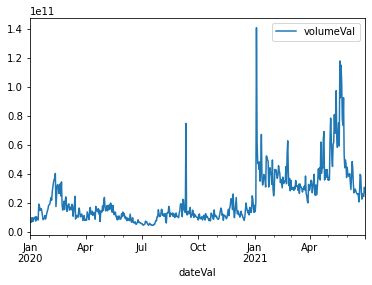

In [176]:
df.plot()

## Analysis and Conclusion

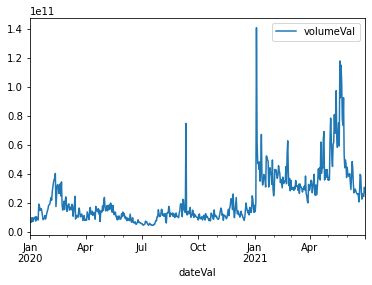

In [177]:
df.plot()

Based on the data we scraped, wrangle, and visualize, we have a plot with the x axis of Date and y axis of Volume.
Period of data is from Jan 2020 until Jun 2021.

Volume on cryptocurrency is defined as the amount of cryptocurrency that has been traded over a set period.
The higher the volume of cryptocurrency transactions, the more liquid the crypto market will be.

Based on the line plot that we have, we can see that early 2020 there were increase of transaction for Ethereum, continued with more stable along the year with a spike of volume seen in September '20 and January '21.

On 2021, Ethereum was getting increase on volume transacted until May '21, where we see a significant volume drop continued until June '21, which corelates with the event's of China's efforts to prohibit mining and trading of cryptocurrencies and Tesla payments on hold due to energy use concerns.